In [199]:
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import ast

In [98]:
df = pd.read_csv('msc_collated_data_20230709.csv')
df.columns

Index(['Unnamed: 0', 'section', 'task_section', 'task', 'trial_id', 'cue_dir',
       'valid_cue', 'key_resp.keys', 'key_resp.rt', 'correct_response',
       'median_left_eye_x', 'mean_left_eye_x', 'participant_number',
       'session_number', 'session_type', 'no_bad_eye_indicies', 'median_aai',
       'mean_aai', 'eyes_open_baseline', 'eyes_closed_baseline',
       'posner_baseline', 'posner_threshold', 'percentage_bad_eye'],
      dtype='object')

In [162]:
# Selecting columns of interest
df_roi = df[['session_number', 
             'session_type', 
             'participant_number', 
             'key_resp.rt', 
             'task', 
             'valid_cue', 
             'cue_dir', 
             'correct_response',
             'mean_aai']]

# Rename RT column
df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)

# Drop nans
df_roi = df_roi.dropna()

# Get first reaction time to usable number
df_roi['rt'] = df_roi['rt'].apply(ast.literal_eval)
df_roi['rt'] = df_roi['rt'].apply(lambda x: x[0])

# Keep only posner tasks
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback2'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback3'].index)
assert df_roi.task.unique()[0]=='posner0'
assert df_roi.task.unique()[1]=='posner1'
assert len(df_roi.task.unique())==2

# Drop invalid trials
df_roi = df_roi.drop(df_roi[df_roi['valid_cue'] == False].index)
assert df_roi.valid_cue.unique()==True

# Keep only left cues
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'centre'].index)
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'right'].index)
assert df_roi.cue_dir.unique()=='left'

# Keep only correct responses:
df_roi = df_roi.drop(df_roi[df_roi['correct_response'] == False].index)
assert df_roi.correct_response.unique()==True

# Just look at session 1 posner a versus session 2 posner b
df_roi = df_roi.drop(df_roi[(df_roi['session_number'] == 'ses-01') & (df_roi['task'] == 'posner1') |
                (df_roi['session_number'] == 'ses-02') & (df_roi['task'] == 'posner0')].index)
# Double check
assert all(df_roi.loc[df_roi['session_number'] == 'ses-01', 'task'] == 'posner0')
assert all(df_roi.loc[df_roi['session_number'] == 'ses-02', 'task'] == 'posner1')

df_roi

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_19197/1456953260.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)


,session_number,session_type,participant_number,rt,task,valid_cue,cue_dir,correct_response,mean_aai
4,ses-01,an-at,sub-00,0.340445,posner0,True,left,True,-0.026283
5,ses-01,an-at,sub-00,0.346403,posner0,True,left,True,-0.051757
9,ses-01,an-at,sub-00,0.324058,posner0,True,left,True,0.022741
10,ses-01,an-at,sub-00,0.382003,posner0,True,left,True,-0.093671
17,ses-01,an-at,sub-00,0.289734,posner0,True,left,True,-0.001150
...,...,...,...,...,...,...,...,...,...
8556,ses-02,an-at,sub-20,0.282708,posner1,True,left,True,-0.230307
8559,ses-02,an-at,sub-20,0.340457,posner1,True,left,True,0.106847
8563,ses-02,an-at,sub-20,0.394256,posner1,True,left,True,-0.001327
8564,ses-02,an-at,sub-20,0.400359,posner1,True,left,True,-0.220601


In [163]:
# Function to determine the group of each participant
def set_group(x):
    if x.nunique() == 2:
        return 'sham'
    else:
        return 'active'

# Apply the function to each participant
df_roi['group'] = df_roi.groupby('participant_number')['session_type'].transform(set_group)
df_roi.group.count()

# Rename session_number values for plotting
df_roi['session_number'] = df_roi['session_number'].replace({'ses-01': 'pos1a', 'ses-02': 'pos2b'})

### Plot condition and session effect on reaction time

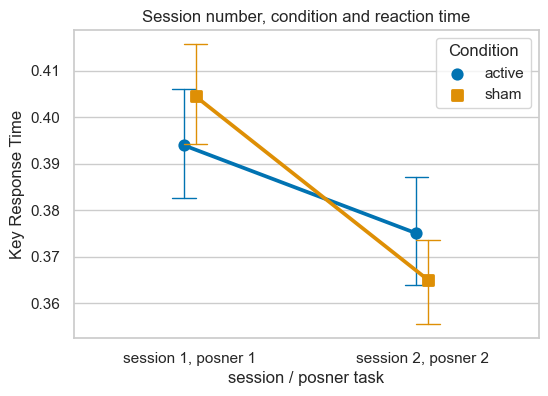

In [181]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
interaction_plot = sns.pointplot(x='session_number', y='rt', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')

plt.title('Session number, condition and reaction time')
plt.xlabel('session / posner task')
plt.ylabel('Key Response Time')
plt.legend(title='Condition')
plt.show()

#### ANOVA for reaction time, session and condition

In [202]:
# Define model
# 'C()' indicates that we want to treat the variables as categorical
# pd.set_option('display.float_format', '{:.3f}'.format)
model = ols('rt ~ C(group) + C(session_number) + C(group):C(session_number)', data=df_roi).fit()

# Create anova table with stats
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# pd.reset_option('display.float_format')

                              sum_sq     df          F        PR(>F)
C(group)                    0.000033    1.0   0.004388  9.472018e-01
C(session_number)           0.193877    1.0  25.549402  5.189742e-07
C(group):C(session_number)  0.024615    1.0   3.243840  7.201556e-02
Residual                    7.072328  932.0        NaN           NaN


## AAI changes?

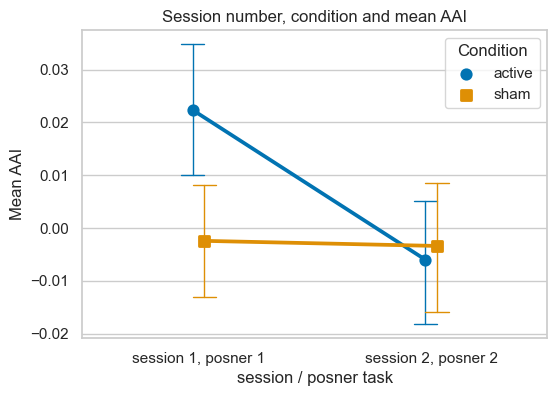

In [182]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
interaction_plot = sns.pointplot(x='session_number', y='mean_aai', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')

plt.title('Session number, condition and mean AAI')
plt.xlabel('session / posner task')
plt.ylabel('Mean AAI')
plt.legend(title='Condition')
plt.show()

#### ANOVA for mean AAI, session and condition

In [203]:
# Define model
# 'C()' indicates that we want to treat the variables as categorical
# pd.set_option('display.float_format', '{:.3f}'.format)
model = ols('mean_aai ~ C(group) + C(session_number) + C(group):C(session_number)', data=df_roi).fit()

# Create anova table with stats
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
# pd.reset_option('display.float_format')

                              sum_sq     df         F    PR(>F)
C(group)                    0.029567    1.0  3.469133  0.062839
C(session_number)           0.053831    1.0  6.316031  0.012133
C(group):C(session_number)  0.043741    1.0  5.132199  0.023715
Residual                    7.943305  932.0       NaN       NaN
